In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os

from CLAPWrapper import CLAPWrapper
from utils.dataset import *
from utils.interventions import Intervention
from utils.activations import save_dataset_activations, clear_hooks
from utils.layerwise import save_pairwise_distances
from utils.clustering import get_cluster_embeddings

from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from einops import rearrange
from torch_scatter import scatter
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from icecream import ic
from tqdm.autonotebook import tqdm
from IPython.display import IFrame
from wand.image import Image as WImage

In [741]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [149]:
seed_everything(42)

In [150]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = 'cpu'

module_activation_dict = {
    # Conv blocks
    'audio_encoder.base.conv_block1': nn.Identity(),    # 0
    'audio_encoder.base.conv_block2': nn.Identity(),    # 1
    'audio_encoder.base.conv_block3': nn.Identity(),    # 2
    'audio_encoder.base.conv_block4': nn.Identity(),    # 3
    'audio_encoder.base.conv_block5': nn.Identity(),    # 4
    'audio_encoder.base.conv_block6': nn.Identity(),    # 5
    'audio_encoder.base.fc1': F.relu,                   # 6
    'audio_encoder.projection.linear1': F.gelu,         # 7
    'audio_encoder.projection.linear2': nn.Identity(),  # 8
}

module_list = list(module_activation_dict.keys())

In [164]:
probing_dataset = ESC50Dataset()
testing_dataset = ESC50Dataset()

Using downloaded and verified file: /scratch/pratyaksh.g/esc50/ESC-50-master.zip


2000it [00:00, 11249.38it/s]

Loading audio files


Using downloaded and verified file: /scratch/pratyaksh.g/esc50/ESC-50-master.zip


895it [00:00, 8945.64it/s]

Loading audio files


2000it [00:00, 8685.67it/s]


In [451]:
layer_idx = 6
layer_name = module_list[layer_idx]
partition_idx = 1
cluster_idx = 2
# treatment = 'intervened' # 'intervened' or 'random' (control using group of random neurons)
invert_mask = False # False will *remove* the activations of the neurons in the cluster

## Plots

In [452]:
pdf_path = f'/scratch/pratyaksh.g/{probing_dataset.path_name}/cluster-plots/{layer_name}/partition-{partition_idx}/'

try:
    for file in os.listdir(pdf_path):
        if file.endswith(f'cluster-{cluster_idx}.pdf'):
            file_path = os.path.join(pdf_path, file)
            break

    print('Cluster embedding pdf: ' + file_path)

    for file in os.listdir(pdf_path):
        if file.endswith(f'posmap-{cluster_idx}.pdf'):
            file_path = os.path.join(pdf_path, file)
            break
    print('Positional embedding pdf: ' + file_path)

except:
    pass

Cluster embedding pdf: /scratch/pratyaksh.g/esc50/cluster-plots/audio_encoder.base.fc1/partition-1/16-cluster-2.pdf
Positional embedding pdf: /scratch/pratyaksh.g/esc50/cluster-plots/audio_encoder.base.fc1/partition-1/16-cluster-2.pdf


In [453]:
if False:
    root = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/intervened-performance/'
    expt_id = lambda treatment: f"{layer_name}/partition-{partition_idx}-cluster-{cluster_idx}-{treatment}-invert_mask=false.csv"

    a1 = pd.read_csv(root + 'normal-performance.csv')
    b1 = pd.read_csv(root + expt_id('intervened'))
    c1 = pd.read_csv(root + expt_id('random'))

    expt_id = lambda treatment: f"{layer_name}/partition-{partition_idx}-cluster-{cluster_idx}-{treatment}-invert_mask=true.csv"

    a2 = pd.read_csv(root + 'normal-performance.csv')
    b2 = pd.read_csv(root + expt_id('intervened'))
    c2 = pd.read_csv(root + expt_id('random'))

    np.array([ic((a1 == a2).all().all()), ic((b1 == b2).all().all()), ic((c1 == c2).all().all())]).all()

In [454]:
class_indices = torch.tensor([testing_dataset.class_to_idx[label] for label in testing_dataset.class_label])

In [594]:
if True:
    clusters_to_plot = [
        # Clean examples
        (6, 1, 7),
        (6, 1, 25),
        (5, 4, 0),
        (5, 4, 9),
        (5, 4, 28),
        (3, 3, 29),
        (4, 4, 11),

        # Secondary class reducing examples
        (4, 2, 541),
        (5, 4, 7),

        # Class confusion examples

        # Nothing happens examples
        (4, 3, 24),

        # interesting example: nothing for selective, big drop for random
        (6, 0, 0),
    ]

    dfs_to_plot = []

    for (layer_idx, partition_idx, cluster_idx) in clusters_to_plot:
        root = '/scratch/pratyaksh.g/'
        layer_name = module_list[layer_idx]
        activations = torch.load(root + f'{testing_dataset.path_name}/activations/{layer_name}.pt')
        clusters = torch.load(root + f'{testing_dataset.path_name}/clusters/{layer_name}.pt')
        n_clusters = torch.load(root + f'{testing_dataset.path_name}/clusters/{layer_name}_n.pt')
        cluster_embeddings = get_cluster_embeddings(activations, clusters, n_clusters)

        clust_embed = cluster_embeddings[partition_idx][cluster_idx]
        classwise_embed = scatter(clust_embed, class_indices, dim=0, reduce='sum')

        df = pd.DataFrame({
            'class': testing_dataset.classes,
            'activation': classwise_embed
        })

        dfs_to_plot.append(df)

In [456]:
root = '/scratch/pratyaksh.g/'
activations = torch.load(root + f'{testing_dataset.path_name}/activations/{layer_name}.pt')
clusters = torch.load(root + f'{testing_dataset.path_name}/clusters/{layer_name}.pt')
n_clusters = torch.load(root + f'{testing_dataset.path_name}/clusters/{layer_name}_n.pt')
cluster_embeddings = get_cluster_embeddings(activations, clusters, n_clusters)

clust_embed = cluster_embeddings[partition_idx][cluster_idx]
classwise_embed = scatter(clust_embed, class_indices, dim=0, reduce='sum')

In [457]:
df = pd.DataFrame({
    'class': testing_dataset.classes,
    'activation': classwise_embed
})

In [603]:
idx = 0
ccav = dfs_to_plot[idx]
layer_idx, partition_idx, cluster_idx = clusters_to_plot[idx]
layer_name = module_list[layer_idx]

root = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/intervened-performance/'
expt_id = lambda treatment: f"{layer_name}/partition-{partition_idx}-cluster-{cluster_idx}-{treatment}-invert_mask={str(invert_mask).lower()}.csv"

normal = pd.read_csv(root + 'normal-performance.csv')
intervened = pd.read_csv(root + expt_id('intervened'))
random = pd.read_csv(root + expt_id('random'))

performance = pd.concat([normal, intervened, random], axis=0)

In [729]:
plt.clf()

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

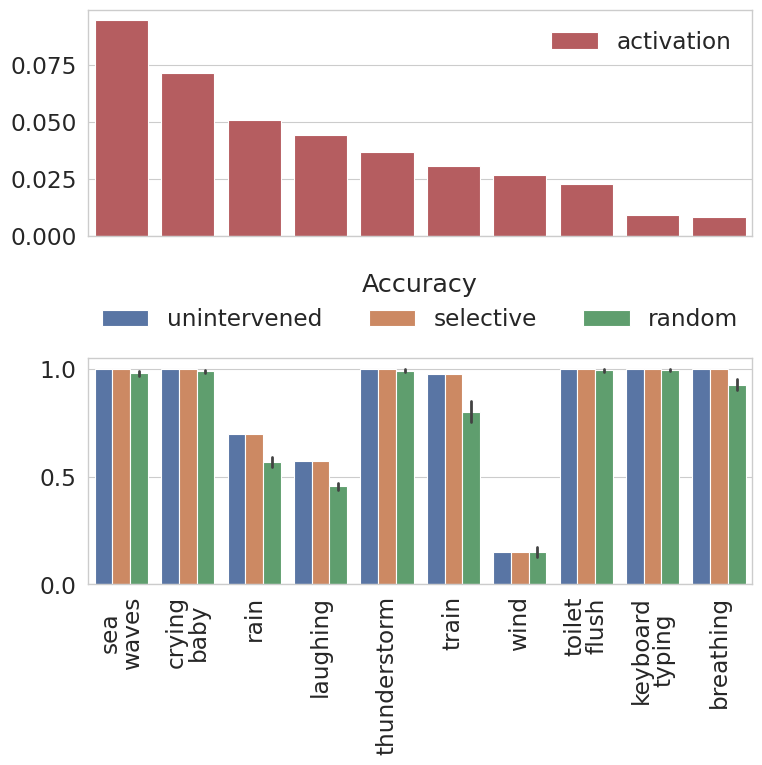

In [733]:
sns.set_theme('paper', style='whitegrid', font_scale=1.9, rc={'figure.figsize': (8, 8)})
plt.clf()
fig, axs = plt.subplots(2, 1, sharex=True)

top_ten_df = ccav.sort_values('activation', ascending=False)[:10]
plt.subplot(2, 1, 1)
sns.barplot(top_ten_df, y='activation', x='class', color=sns.color_palette()[3], label='activation')
h1, l1 = plt.gca().get_legend_handles_labels()
plt.legend(h1, ['activation'], loc='upper right', bbox_to_anchor=(1, 1), frameon=False)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 1, 2)
sns.barplot(data=pd.concat([performance[performance['label'] == label] for label in top_ten_df['class']]),
            x='label', y='accuracy', hue='treatment', errwidth=2)
xlabels = top_ten_df['class']
xlabels = [label.replace(' ', '\n') for label in xlabels]
plt.xticks(ticks=range(10), labels=xlabels, linespacing=0.95)
plt.xlabel('')
plt.ylabel('')

h2, l2 = plt.gca().get_legend_handles_labels()
plt.legend(h2, ['unintervened', 'selective', 'random'], title='Accuracy', loc='center', ncol=3, bbox_to_anchor=(0.5, 1.25), frameon=False)

plt.xticks(rotation=90)

fig.tight_layout(h_pad=0)
plt.savefig(f'/scratch/pratyaksh.g/paper-plots/l{layer_idx}p{partition_idx}c{cluster_idx}.pdf')

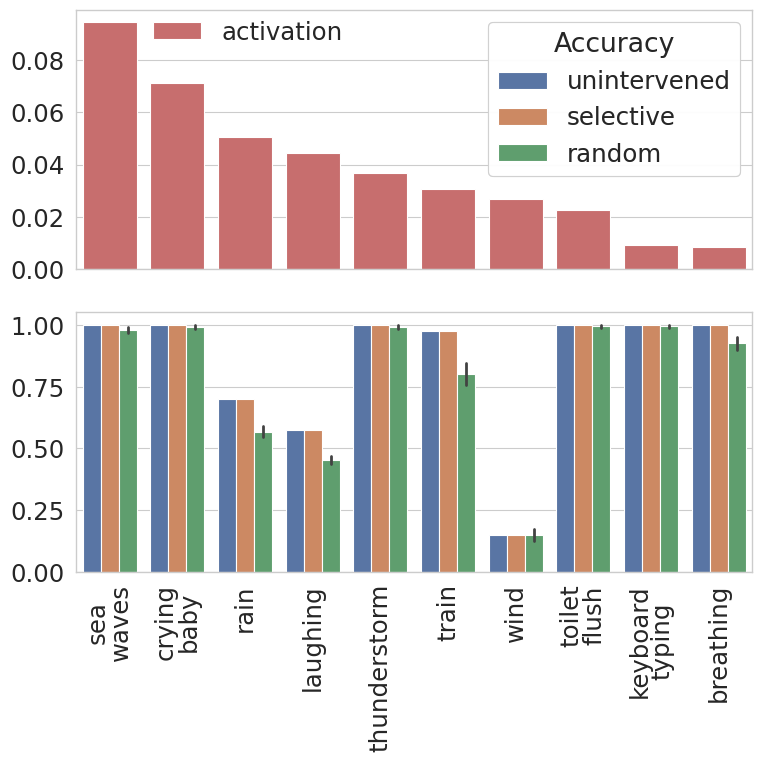

In [694]:
sns.set_theme('paper', style='whitegrid', font_scale=2, rc={'figure.figsize': (8, 8)})
fig, axs = plt.subplots(2, 1, sharex=True)

top_ten_df = ccav.sort_values('activation', ascending=False)[:10]
plt.subplot(2, 1, 1)
sns.barplot(top_ten_df, y='activation', x='class', color=sns.color_palette('muted')[3], label='activation')
h1, l1 = plt.gca().get_legend_handles_labels()
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 1, 2)
sns.barplot(data=pd.concat([performance[performance['label'] == label] for label in top_ten_df['class']]),
            x='label', y='accuracy', hue='treatment', errwidth=2)
xlabels = top_ten_df['class']
xlabels = [label.replace(' ', '\n') for label in xlabels]
plt.xticks(ticks=range(10), labels=xlabels, linespacing=0.95)
plt.xlabel('')
plt.ylabel('')

h2, l2 = plt.gca().get_legend_handles_labels()
plt.gca().get_legend().remove()
plt.xticks(rotation=90)

plt.subplot(2, 1, 1)
legend1 = plt.legend(h1, ['activation'], loc='upper left', bbox_to_anchor=(0.081, 1.043), frameon=False)
legend2 = plt.legend(h2, ['unintervened', 'selective', 'random'], title='Accuracy', loc='upper right')
ax = plt.gca()
ax.add_artist(legend1)
ax.add_artist(legend2)

fig.tight_layout()
plt.savefig(f'/scratch/pratyaksh.g/paper-plots/l{layer_idx}p{partition_idx}c{cluster_idx}.pdf')

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

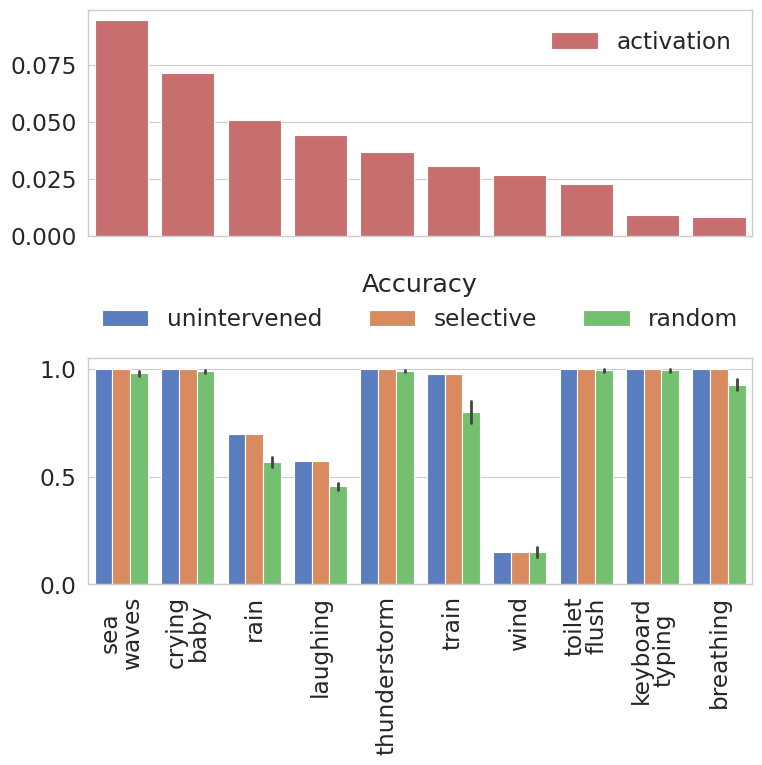

In [740]:
for idx in range(len(dfs_to_plot)):
    ccav = dfs_to_plot[idx]
    layer_idx, partition_idx, cluster_idx = clusters_to_plot[idx]
    layer_name = module_list[layer_idx]

    root = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/intervened-performance/'
    expt_id = lambda treatment: f"{layer_name}/partition-{partition_idx}-cluster-{cluster_idx}-{treatment}-invert_mask={str(invert_mask).lower()}.csv"

    normal = pd.read_csv(root + 'normal-performance.csv')
    intervened = pd.read_csv(root + expt_id('intervened'))
    random = pd.read_csv(root + expt_id('random'))

    performance = pd.concat([normal, intervened, random], axis=0)

    sns.set_theme('paper', style='whitegrid', font_scale=1.9, rc={'figure.figsize': (8, 8)})
    plt.clf()
    fig, axs = plt.subplots(2, 1, sharex=True)

    top_ten_df = ccav.sort_values('activation', ascending=False)[:10]
    plt.subplot(2, 1, 1)
    sns.barplot(top_ten_df, y='activation', x='class', color=sns.color_palette('muted')[3], label='activation')
    h1, l1 = plt.gca().get_legend_handles_labels()
    plt.legend(h1, ['activation'], loc='upper right', bbox_to_anchor=(1, 1), frameon=False)
    plt.xlabel('')
    plt.ylabel('')

    plt.subplot(2, 1, 2)
    sns.barplot(data=pd.concat([performance[performance['label'] == label] for label in top_ten_df['class']]),
                x='label', y='accuracy', hue='treatment', errwidth=2, palette=sns.color_palette('muted'))
    xlabels = top_ten_df['class']
    xlabels = [label.replace(' ', '\n') for label in xlabels]
    plt.xticks(ticks=range(10), labels=xlabels, linespacing=0.95)
    plt.xlabel('')
    plt.ylabel('')

    h2, l2 = plt.gca().get_legend_handles_labels()
    plt.legend(h2, ['unintervened', 'selective', 'random'], title='Accuracy', loc='center', ncol=3, bbox_to_anchor=(0.5, 1.25), frameon=False)

    plt.xticks(rotation=90)

    fig.tight_layout(h_pad=0)
    plt.savefig(f'/scratch/pratyaksh.g/paper-plots/l{layer_idx}p{partition_idx}c{cluster_idx}.pdf')

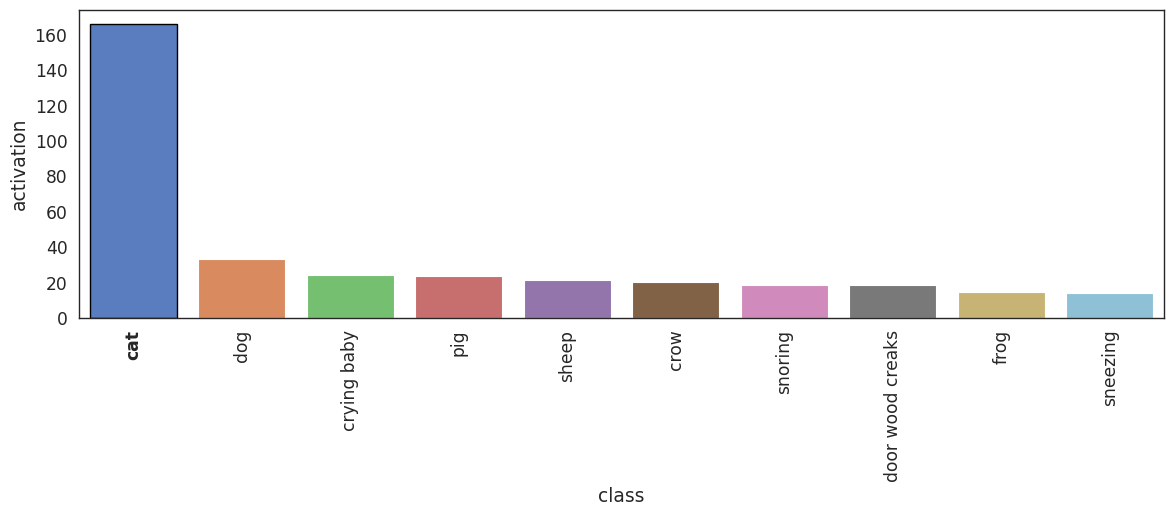

In [473]:
sns.set_theme('paper', style='white', font_scale=1.4, rc={'figure.figsize': (14, 4)})
sns.barplot(y='activation', x='class',
            data= df.sort_values('activation', ascending=False)[:10],
            palette=sns.color_palette('muted'))
plt.xticks(rotation=90)

ax = plt.gca()
highlighted_class = 'cat'
for idx, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == highlighted_class:
        label.set_fontweight('bold')
        ax.patches[idx].set_edgecolor('black')
        ax.patches[idx].set_linewidth(1)

In [460]:
root = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/intervened-performance/'
expt_id = lambda treatment: f"{layer_name}/partition-{partition_idx}-cluster-{cluster_idx}-{treatment}-invert_mask={str(invert_mask).lower()}.csv"

normal = pd.read_csv(root + 'normal-performance.csv')
intervened = pd.read_csv(root + expt_id('intervened'))
random = pd.read_csv(root + expt_id('random'))

In [461]:
root + expt_id('intervened')

'/scratch/pratyaksh.g/esc50/intervened-performance/audio_encoder.base.fc1/partition-1-cluster-2-intervened-invert_mask=false.csv'

In [462]:
performance = pd.concat([normal, intervened, random], axis=0)

In [463]:
plot_path = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/intervened-plots/{layer_name}/'
os.makedirs(plot_path, exist_ok=True)

<Figure size 1400x400 with 0 Axes>

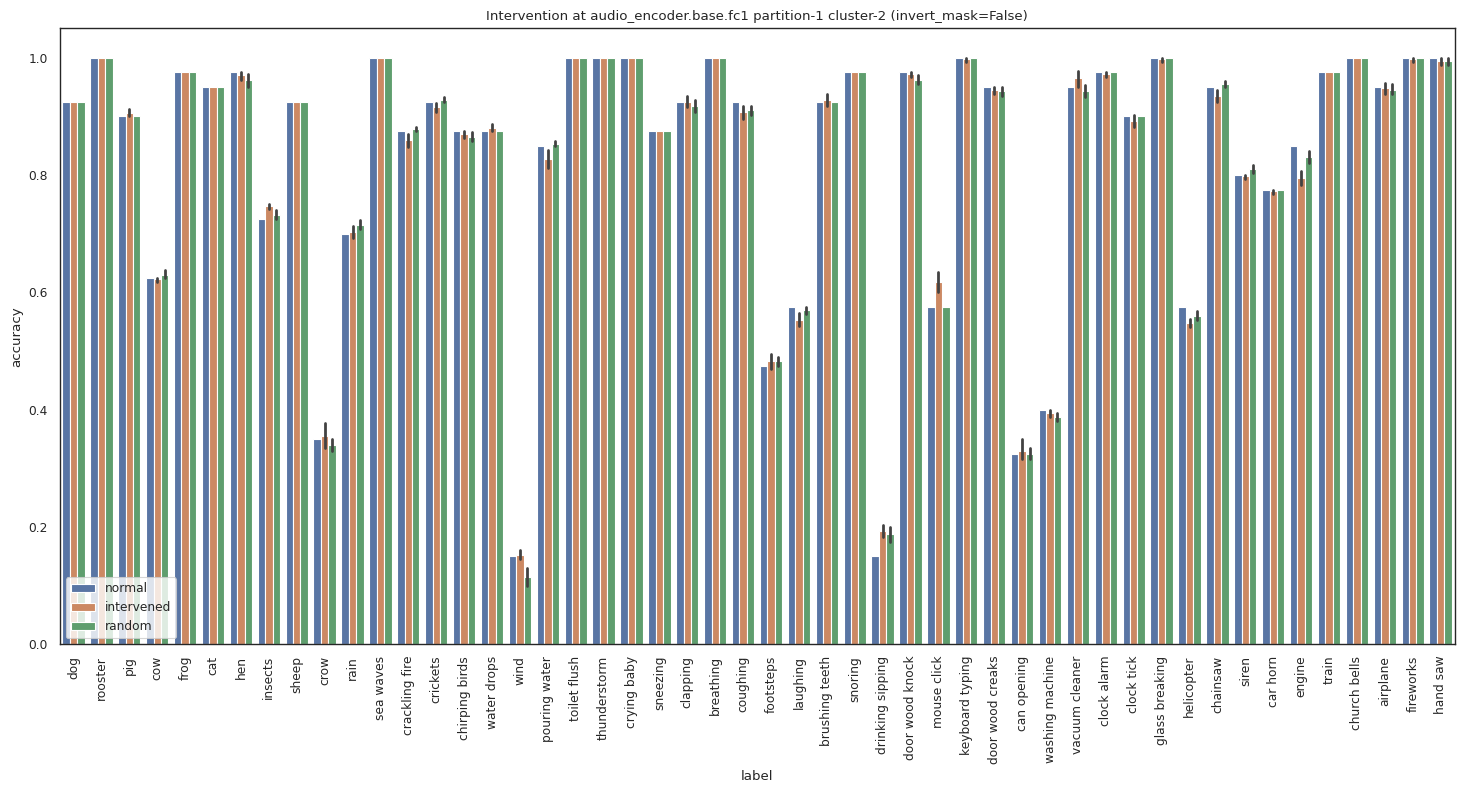

In [464]:
plt.clf()
plt.figure(figsize=(18, 8))
sns.set_theme('paper', style='white')
sns.barplot(data=performance, x='label', y='accuracy', hue='treatment', errwidth=2)
plt.title(f"Intervention at {layer_name} partition-{partition_idx} cluster-{cluster_idx} (invert_mask={str(invert_mask)})")
plt.legend(loc='lower left')
plt.xticks(rotation=90)
plt.savefig(plot_path + f"p{partition_idx}-c{cluster_idx}-{probing_dataset.path_name}-invert_mask={str(invert_mask)}.png")